# Classification of artists using Machine Learning methods based on their lyrics

# ______________________________________________________________

## Import libraries

In [176]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import string
import re
import os

from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

import wordcloud
from wordcloud import WordCloud 
from sklearn.feature_extraction import _stop_words
skl_stopwords=_stop_words.ENGLISH_STOP_WORDS

lemmatizer = WordNetLemmatizer()
tokenizer= TreebankWordTokenizer()

import seaborn as sns
import matplotlib.pyplot as plt

## Creating a Corpus

In [177]:
def create_corpus(folders, base_url):
    """This functions creates corpus(list) of all the lyrics for given artists
       This function required 2 input arguments:
           1. A list of all the artists(folder_name) where the lyrics are stored
           2. base_url where the lyrics folder is stored
           
               eg: folder = ['Eminem','Jay-Z','Justin-Timberlake','50-Cent','Bob-Marley','Michael-Jackson']
                   base_url =r"C:/Users/Asus/OneDrive/Desktop/Spiced_Academy/naive-zatar-student-codes/week4/"
                   """
    
    #folders = ['Eminem','Jay-Z','Justin-Timberlake','50-Cent','Bob-Marley','Michael-Jackson']
    global corpus 
    corpus = []# initilizing corpus empty list 
    global file_list_
    file_list_ = [] #initilizing lyrics files empty list
    global folder_len
    folder_len = [] # initilizing empty folder_len list
     
    #base_url = r"C:/Users/Asus/OneDrive/Desktop/Spiced_Academy/naive-zatar-student-codes/week4/"

    for folder in folders:
        full_path = base_url+folder
        #file_list_[folder] = os.listdir(full_path)
        folder = os.listdir(full_path)
        folder_len.append(len(folder))
        #print(folder)
        for filename in folder:
            final_path = full_path+'/'+ filename
            #print(final_path)

            with open(final_path, 'r',encoding="utf8") as f:
                bob_marley = f.read()
                corpus.append(bob_marley)
                f.close()
    global labels
    labels = [] # initilizing empty labels list
    for name , i in zip(folders, folder_len):
        labels.append([name]*i)
    labels = [ item for elem in labels for item in elem]  
    
    
    return len(corpus)

In [178]:
folders = ['Eminem','Jay-Z','Justin-Timberlake','50-Cent','Bob-Marley','Michael-Jackson']
base_url = r"C:/Users/Asus/OneDrive/Desktop/Spiced_Academy/naive-zatar-student-codes/week4/"
create_corpus(folders, base_url)

1948

## Processing the text by tokenizing and lemmatizing

In [179]:
def remove_char(text_list):
    global Corpus
    Corpus = []
    for i in text_list:
        newstr = i.replace("\n", " ")
        Corpus.append(newstr)
    return(len(Corpus))

In [180]:
def tokenize_lemmatize(text, stopwords=skl_stopwords, tokenizer=tokenizer, lemmatizer=lemmatizer):
    panc = string.punctuation + '–'+ '‘'+ '’'+ '“'+'”'
    text = [i for i in text if not re.findall("[^\u0000-\u05C0\u2100-\u214F]+",i)]
    text = ''.join([ch for ch in text if ch not in panc]) #remove punctuation
    text = re.sub(pattern= '[0-9]+', string= text, repl = ' ' )
    text = re.sub(pattern = '(aah|aaaa|aa)', string = text, repl ='')
    tokens = nltk.word_tokenize(text) 
    return [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords] 

In [181]:
remove_char(corpus)

1948

In [182]:
vectorizer = CountVectorizer(tokenizer=tokenize_lemmatize,encoding='utf-8', stop_words=None)
X = vectorizer.fit_transform(Corpus)
lyric_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out())                     

In [183]:
print(folders)

['Eminem', 'Jay-Z', 'Justin-Timberlake', '50-Cent', 'Bob-Marley', 'Michael-Jackson']


In [184]:
Labels = pd.DataFrame(labels, columns=['artist']) # inserting label col to the lyric_df dataframe.
Labels['artist'] = Labels['artist'].map({'Eminem':0,'Jay-Z':1,'Justin-Timberlake':2,'50-Cent':3, 'Bob-Marley':4, 'Michael-Jackson':5})

## Train and Test

In [185]:
def random_over_sample(data_frame, labels):
    """This function return oversampled dataframe for imbalanced data
        Required two input:
        1. data_frame will be independent variable
        2. labels will be dependent variable"""
    
    global X_ros
    global y_ros
    ros = RandomOverSampler(random_state=10, sampling_strategy="auto")
    X_ros, y_ros = ros.fit_resample(lyric_df, Labels)
    return

In [186]:
random_over_sample(lyric_df, Labels)
print(f'unique samples in each class (oversampled): \n{y_ros.value_counts()}')

unique samples in each class (oversampled): 
artist
0         579
1         579
2         579
3         579
4         579
5         579
dtype: int64


In [187]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_ros, y_ros, test_size=.40, random_state= 42)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((2084, 22833), (1390, 22833), (2084, 1), (1390, 1))

In [188]:

Xval, X_test, yval, y_test = train_test_split(Xtest, ytest, test_size=.50, random_state= 42)
Xval.shape, X_test.shape, yval.shape, y_test.shape

((695, 22833), (695, 22833), (695, 1), (695, 1))

In [189]:
tf = TfidfTransformer() 
Xtrain_norm = tf.fit_transform(Xtrain)

In [190]:
Xtrain_norm=pd.DataFrame(Xtrain_norm.todense(), columns=vectorizer.get_feature_names_out())
Xtrain_norm.shape

(2084, 22833)

## Random Forest Classifier

In [191]:
from sklearn.ensemble import RandomForestClassifier
import multiprocessing

In [192]:
%%time
#n_estimators= 5000,min_samples_split= 350,min_samples_leaf= 7, max_depth=1000, random_state=101
RFC  = RandomForestClassifier(n_estimators=1000,min_samples_split=250,min_samples_leaf=30, max_depth=1000, random_state=101).fit(Xtrain_norm, ytrain.values.ravel())

# .values will give the values in a numpy array (shape: (n,1))
# .ravel will convert that array shape to (n, ) (i.e. flatten it)

Wall time: 17.9 s


In [193]:
Xval_norm = tf.transform(Xval)

In [194]:
Xval_norm=pd.DataFrame(Xval_norm.todense(), columns=vectorizer.get_feature_names_out())

In [195]:
ypred_rfc = RFC.predict(Xval_norm)

In [196]:
print(f'Training score {round(RFC.score(Xtrain_norm, ytrain)*100,2)}%')
print(f'Validation score {round(RFC.score(Xval_norm, yval)*100,2)}%')

Training score 74.42%
Validation score 72.09%


In [197]:
X_test_norm = tf.transform(X_test)
X_test_norm=pd.DataFrame(X_test_norm.todense(), columns=vectorizer.get_feature_names_out())
ypred_rfc = RFC.predict(X_test_norm)

In [198]:
print(f'Training score {round(RFC.score(Xtrain_norm, ytrain)*100,2)}%')
print(f'Validation score {round(RFC.score(X_test_norm, y_test)*100,2)}%')

Training score 74.42%
Validation score 72.95%


## Heat Map

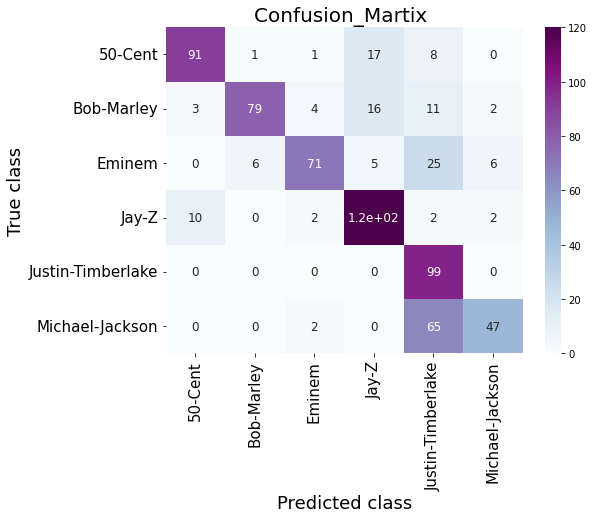

In [221]:
corr_map = confusion_matrix(y_test, ypred_rfc, normalize=None)
fig, axs = plt.subplots(1,1, figsize=(8,6), facecolor='w', edgecolor='k')
sns.heatmap(corr_map,
                    annot=True,
                    cmap='BuPu',
                    annot_kws={"size":12}
                    )
        
axs.set_ylabel("True class",fontsize=18)
axs.set_xlabel("Predicted class",fontsize=18)
axs.set_title(f'Confusion_Martix ',fontsize=20)
axs.set_xticklabels(np.unique(folders),fontsize=15,rotation=90)
axs.set_yticklabels(np.unique(folders),fontsize=15,rotation=0)
plt.show()

## Word Cloud

In [69]:
# converting list to dataframe of lyrics
Corp_DF = pd.DataFrame({'lyrics':Corpus,'artist_name':labels})

In [174]:
def mk_WordCloud(artist_name):
    """ This function will make word cloud for all the artists
        Parameters:
            It required only one parameter: --list of artist name
            eg: ['Eminem','Jay-Z','Justin-Timberlake','50-Cent','Bob-Marley','Michael-Jackson']
    """
    for i,artist in enumerate(artist_name):
        i = i+1
        print('-'*110)
        print(i,'.','#'*30,artist,'#'*30)
        print('-'*110)
        artist_ = Corp_DF[Corp_DF['artist_name'] == artist]
        
        wordCloud = WordCloud(
            background_color="black", 
            width=1600, 
            height=800,
            stopwords=skl_stopwords).generate(' '.join(artist_.lyrics))
        
        plt.figure(figsize=(15,10), facecolor='k')
        plt.imshow(wordCloud,interpolation="bilinear")
        plt.axis("off")
        plt.show()
    


--------------------------------------------------------------------------------------------------------------
1 . ############################## Eminem ##############################
--------------------------------------------------------------------------------------------------------------


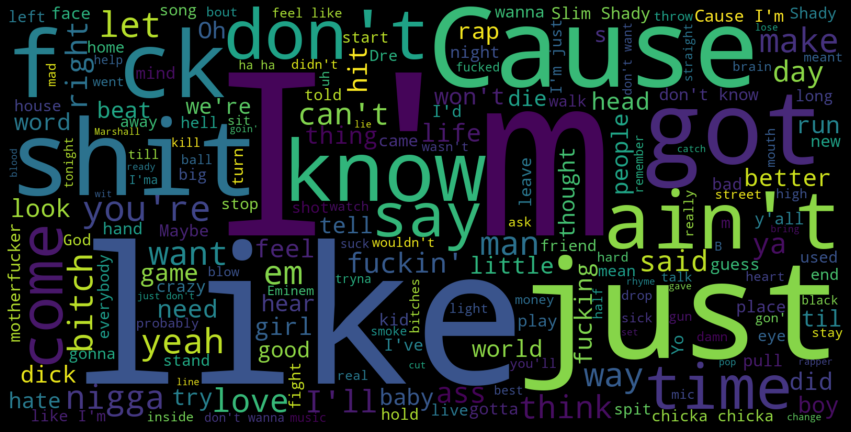

--------------------------------------------------------------------------------------------------------------
2 . ############################## Jay-Z ##############################
--------------------------------------------------------------------------------------------------------------


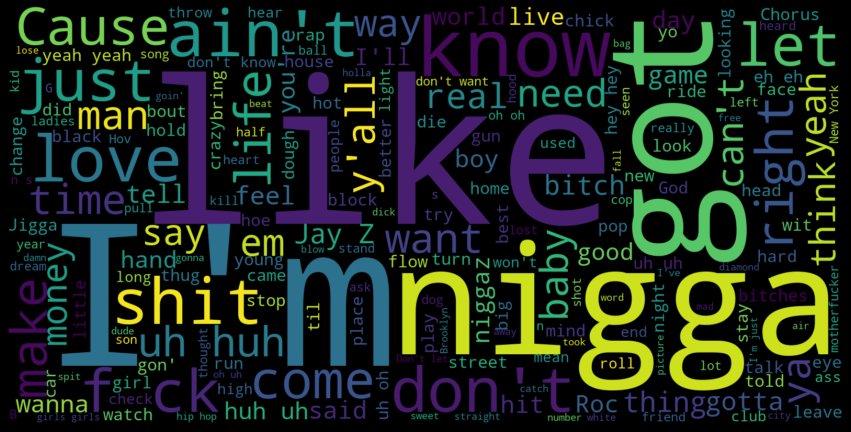

--------------------------------------------------------------------------------------------------------------
3 . ############################## Justin-Timberlake ##############################
--------------------------------------------------------------------------------------------------------------


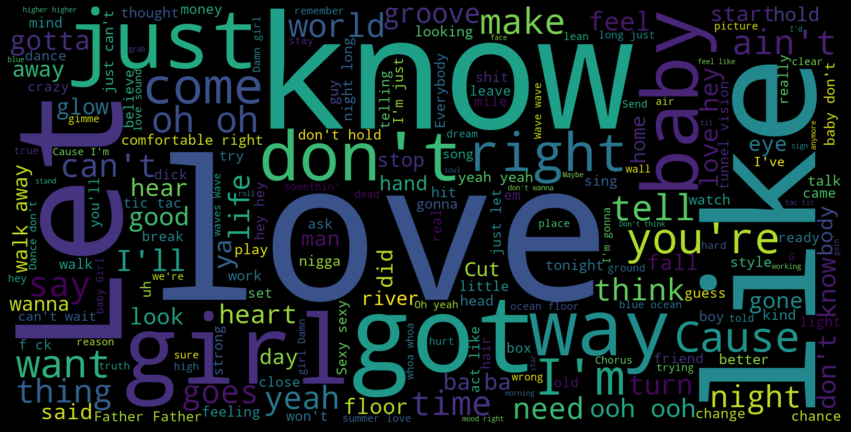

--------------------------------------------------------------------------------------------------------------
4 . ############################## 50-Cent ##############################
--------------------------------------------------------------------------------------------------------------


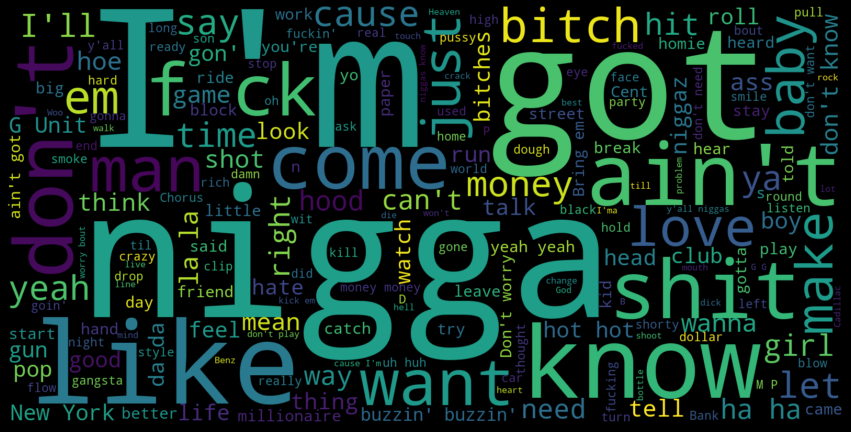

--------------------------------------------------------------------------------------------------------------
5 . ############################## Bob-Marley ##############################
--------------------------------------------------------------------------------------------------------------


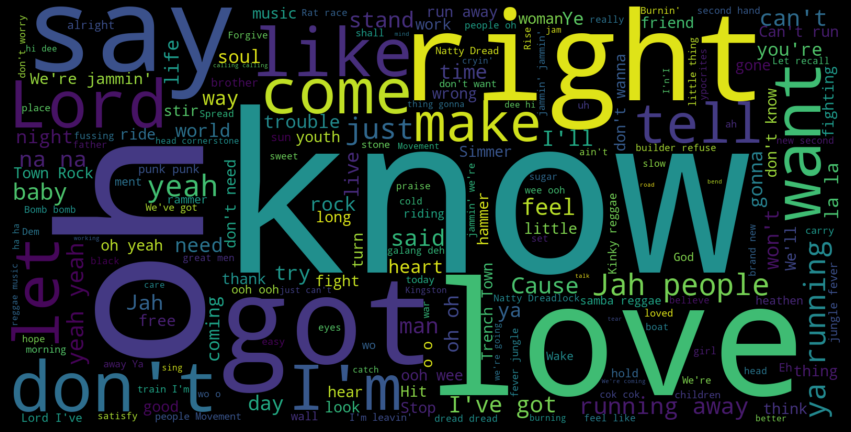

--------------------------------------------------------------------------------------------------------------
6 . ############################## Michael-Jackson ##############################
--------------------------------------------------------------------------------------------------------------


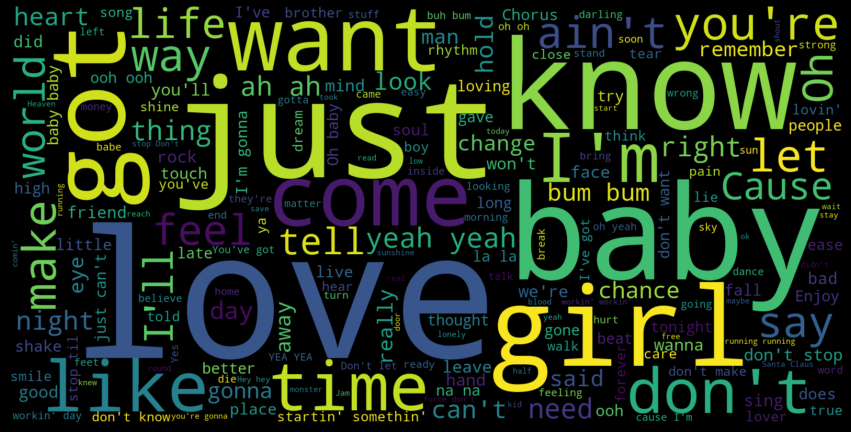

In [175]:
# plot all the wordcloud from different artist
artist_name = ['Eminem','Jay-Z','Justin-Timberlake','50-Cent','Bob-Marley','Michael-Jackson']
mk_WordCloud(artist_name)